In [1]:
%%javascript
<!-- Ignore this block -->
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%config InlineBackend.figure_format = 'retina'

from __future__ import division
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import rankdata


"""Set global rcParams for pyplotlib"""
plt.rcParams["figure.figsize"] = "15, 30"

### TextEncoder

Here the data is mix of numbers and text. Text value cannot be directly used and should be converted to numeric data.<br>
For this I have created a function text encoder which accepts a pandas series. Text encoder returns a lookUp dictionary for recreating the numeric value for text value and encoded text vector.
For encoding I have applied a lambda function that will return value from dictionary.

In [3]:
""" Converts the text features into numeric values so that they can be used by 
the downstream algorithms. 
Accepts pandas series and returns lookup dictionary and encoded vector"""

def textEncoder(textVector):
    if type(textVector) == pd.core.series.Series:
        
        lookUpDictionary = {}
        lookupValue = 0
        for key in textVector.unique():
            lookUpDictionary[key] = lookupValue
            lookupValue +=1
        
        textVector = textVector.apply(lambda a: lookUpDictionary[a])
        return lookUpDictionary,textVector
            
        
    else:
        raise TypeError("Expected a pandas series as an input")   

### generatePearsonCoefficient Procedure
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/f76ccfa7c2ed7f5b085115086107bbe25d329cec">
For sample:-
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/bd1ccc2979b0fd1c1aec96e386f686ae874f9ec0">
For selecting some features and for dropping others I am using Pearson's Coefficient. The value of Pearson's coefficient lies between [-1, 1] and tells how two features are related<br>
<table>
<tr><td>Strength of Association</td><td>Positive</td><td>Negative</td></tr><tr><td>Small</td><td>.1 to .3  </td><td>-0.1 to -0.3  </td></tr><tr><td>Medium</td><td>.3 to .5  </td><td>-0.3 to -0.5  </td></tr><tr><td>Large</td><td>.5 to 1.0 </td><td>-0.5 to -1.0  </td></tr></table>


In [4]:
"""Generate pearson's coefficient"""

def generatePearsonCoefficient(A, B):
    A = A - A.mean()
    B = B - B.mean()
    return ((A * B).sum())/(sqrt((A * A).sum()) * sqrt((B * B).sum())) 

## generateSpearmanCoefficient
https://en.m.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient

If the data is categorical we cannot use pearson's coeffecient as it assumes that data comes from normal distribution.<br>
However Spearman's coefficient is appropriate for both continuous and discrete ordinal variables.<br>

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/a8dda555d22080d721679401fa13181cad3863f6"/>

This is same as pearson's coefficient applied to ranked values

In [5]:
def generateSpearmanCoefficient(x, y):
    
    """Rank the values"""
    n = len(x)
    xRanked = rankdata(x)
    yRanked = rankdata(y)
    
    """Generate Paerson's constant on ranked data"""
    return generatePearsonCoefficient(xRanked, yRanked)
    
    

## SplitDataSet Procedure
This method splits the dataset into trainset and testset based upon the trainSetSize value. For splitting the dataset, I am using pandas.sample to split the data. This gives me trainset. For testset I am calculating complement of the trainset. This I am doing by droping the index present in training set.

In [6]:
"""Splits the provided pandas dataframe into training and test dataset"""
def splitDataSet(inputDataframe, trainSetSize):
    
        trainSet = inputDataframe.sample(frac = trainSetSize)
        testSet = inputDataframe.drop(trainSet.index)
        return trainSet, testSet

## Logistic function
We are using sigmoid as a logistic function defined as <img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/9537e778e229470d85a68ee0b099c08298a1a3f6">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png">
This function calculates probabilities using sigmoid function


In [7]:
def logisticFunction(x):
    return 1.0/(1.0 + np.exp(-x))

## logLikelihood procedure

In [8]:
def logLikelihood(x, beta, y):
    betaX = np.dot(beta, x.T)
    return (np.dot(y, betaX) - np.log(1 + np.exp(betaX))).sum()

## Generate logLoss procedure
For binary classification
<img src="http://wiki.fast.ai/images/math/a/4/6/a4651d4ad311666c617d57c1dde37b28.png">

In [9]:
def logLoss(y, p):
    return -(y * np.log(p) + (1 - y) * np.log(1 - p)).sum()

## boldDriverStepLengthController procedure
This variant is for classifiation problems. 

In [10]:
def boldDriverStepLengthController(alpha, alphaPlus, alphaMinus, fNew, fOld):
    alpha = alpha * alphaPlus
    
    """If the function values are decreasing. Increase alpha"""
    if fNew < fOld:
        alpha = alphaPlus * alpha
    else:
        """If function value is increasing. Decrease alpha"""
        alpha = alphaMinus * alpha
    
    return alpha

## Adagrad procedure
Adaptive gradient descent steplength controller


In [11]:
"""Will provide seperate steplength controller for each beta """

def adagradController(initialStepLength, gradient, history = 0, epsilon = 1.0e-12):
    history = history + (gradient * gradient) + epsilon
    return (initialStepLength * 1.0)/np.sqrt(history), history

# Using gradient ascent
Here loglikelihood is being used making this problem of expectation maximization. The goal is to maximize the loglikelihood and hence gradient ascent is used. It should be noted that same can be done using gradient descent. In this case log loss will be used and objective will be to minimize the log loss. If logloss is used the gradient will be X<sup>T</sup>(P-Y) which is -ve of gradient for loglikelihood(X<sup>T</sup>(P-Y))

## Logistic regression (Gradient ascent)

In [12]:
def logisticRegression(x, y, xTest, yTest, beta, alpha, maxIterations = 1000, epsilon = 1.0e-12):
            
    """Add bias to x"""
    x = np.insert(x, 0, 1, axis = 1)
    xTest = np.insert(xTest, 0, 1, axis = 1)
    
    """Changing the data type to float"""
    x = x * 1.0
    y = y * 1.0
    xTest = xTest * 1.0
    yTest = yTest * 1.0
    
    xTranspose = x.T
    xTransposeTest = xTest.T
    
    betaX = np.dot(beta, xTranspose)
    
    """Calculating log likelihood"""
    logLikelihood = (y * betaX - np.log(1 + np.exp(betaX))).sum()
    
    """For plotting graphs"""
    iterationCount = []
    functionDifference = []
    logLossList = []
    logLikelihoodTrain = []
    logLikelihoodTest = []
    
    for i in range (0, maxIterations):
        
        """Calculate probability"""
        p = logisticFunction(betaX)
            
        """Here we are adding gradient as the we are trying to
        maximize the log likelihood and not minimize it"""
        gradient = np.dot(xTranspose, y - p)

        beta = beta + (alpha * gradient)
        
        betaX = np.dot(beta, xTranspose)
        logLikelihoodNew = (y * betaX - np.log(1 + np.exp(betaX))).sum()
        
        
        """For plotting graphs"""
        iterationCount.append(i)
        functionDifference.append(abs(logLikelihoodNew - logLikelihood))
        predictionTest = logisticFunction(np.dot(beta, xTransposeTest))
        logLossList.append(logLoss(yTest, predictionTest))
        logLikelihoodTrain.append(logLikelihoodNew)
        betaXTest = np.dot(beta, xTransposeTest)
        logLikelihoodTest.append((yTest * betaXTest - np.log(1 + np.exp(betaXTest))).sum())
        
        """Convergence condition"""
        if (abs(logLikelihoodNew - logLikelihood) < epsilon):
            return beta, iterationCount, functionDifference, logLossList, logLikelihoodTrain, logLikelihoodTest
    
        logLikelihood = logLikelihoodNew
        
    print("WARNING algorithm failed to converge")
    return beta, iterationCount, functionDifference, logLossList, logLikelihoodTrain, logLikelihoodTest

## stochasticGradientAscent
Instead of calculating the gradient for entire dataset, stochastic gradient descent/ascent will iterate over samples and update the gradient in each iteration. Stochastic gradient descent/ascent takes more iterations to converge however the time taken is less for large datasets when compared to gradient ascent/descent

In [13]:
def stochasticLogisticRegression(xTrain, yTrain, xTest, yTest, beta, alpha, 
                                 epochs = 4, epsilon = 1.0e-12, 
                                 stepLengthController = None, stepLengthControllerParameters = None):
    
    
    if stepLengthController != None:
        print("Warning using stepLengthController alpha values will be rewritten")

            
    """Add bias to x"""
    xTrain = np.insert(xTrain, 0, 1, axis = 1)
    xTest = np.insert(xTest, 0, 1, axis = 1)
    
    """Changing the data type to float"""
    xTrain = xTrain * 1.0
    yTrain = yTrain * 1.0
    xTest = xTest * 1.0
    yTest = yTest * 1.0
       
    """For plotting graphs"""
    iterationCount = []
    functionDifference = []
    logLossList = []
    logLikelihoodTrain = []
    logLikelihoodTest = []
    
    """Index"""
    indices = range(0, len(xTrain))

    """Calculating log likelihood"""
    logLikelihood = (yTrain * np.dot(beta, xTrain.T) - np.log(1 + np.exp(np.dot(beta, xTrain.T)))).sum()
    logLikelihoodNew = logLikelihood 
    
    history = 0
    for i in range (0, epochs):
        
        """Shuffle the indices"""                        
        np.random.shuffle(indices)
        
        for index in indices:    
            x = xTrain[index]
            y = yTrain[index]
        
            """Calculate probability"""
            betaX = np.dot(beta, x.T)
            p = logisticFunction(betaX)
            
            """Here we are adding gradient as the we are trying to
            maximize the log likelihood and not minimize it"""
            gradient = np.dot(x.T, y - p)
            
            
            """AdagradController is executed for each sample"""
            if stepLengthController == adagradController:
                alpha, history = stepLengthController(gradient = gradient, history = history, **stepLengthControllerParameters)

            beta = beta + (alpha * gradient)
        
            """For plotting graphs"""
        iterationCount.append(i)
        logLikelihoodTrain.append(logLikelihood)
        
        betaXTest = np.dot(beta, xTest.T)
        logLikelihoodTest.append((yTest * betaXTest - np.log(1 + np.exp(betaXTest))).sum())
        
        predictionTest = logisticFunction(np.dot(beta, xTest.T))
        logLossList.append(logLoss(yTest, predictionTest))
        
        """Calculating log likelihood"""
        logLikelihood = logLikelihoodNew
        logLikelihoodNew = (yTrain * np.dot(beta, xTrain.T) - np.log(1 + np.exp(np.dot(beta, xTrain.T)))).sum()
        functionDifference.append(abs(logLikelihoodNew - logLikelihood))
        
        """Bold driver is executed at end of epoch"""
        if stepLengthController == boldDriverStepLengthController:
                alpha = stepLengthController(fNew = logLikelihoodNew, alpha = alpha, fOld = logLikelihood, **stepLengthControllerParameters)
 
    return beta, iterationCount, functionDifference, logLossList, logLikelihoodTrain, logLikelihoodTest

### Prediction for gradient descent

In [14]:
def predictionBinaryClassifier(x, beta):
    """Add bias to x"""
    x = np.insert(x, 0, 1, axis = 1)
    probability = logisticFunction(np.dot(beta, x.T))
    func = np.vectorize(lambda x: 1 if x >=0.5 else 0)
    
    return probability

## Feature scaling
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/358923abc154221bb5022fc329061f6fc4dcc69f">

In [15]:
def scaleFeature(x):
    minX = min(x)
    maxX = max(x)
    return x.apply(lambda y: ((y * 1.0) - minX)/(maxX - minX))

### Load required data

In [16]:
""" File path change accordingly"""
directoryPath = "Data"


tmp1 = pd.read_csv(directoryPath+"/datatraining.txt", sep=',')
tmp2 = pd.read_csv(directoryPath+"/datatest.txt", sep=',')
tmp3 = pd.read_csv(directoryPath+"/datatest2.txt", sep=',')

occupancyData = pd.concat([tmp1, tmp2, tmp3])
occupancyData.head(10)


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.180,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.150,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.150,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.150,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.100,27.2000,426.0,704.500000,0.004757,1
6,2015-02-04 17:55:59,23.100,27.2000,419.0,701.000000,0.004757,1
7,2015-02-04 17:57:00,23.100,27.2000,419.0,701.666667,0.004757,1
8,2015-02-04 17:57:59,23.100,27.2000,419.0,699.000000,0.004757,1
9,2015-02-04 17:58:59,23.100,27.2000,419.0,689.333333,0.004757,1
10,2015-02-04 18:00:00,23.075,27.1750,419.0,688.000000,0.004745,1


## Dataset Description
Source:https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#
<ul>
<li>date</li>
<li>Temperature</li>
<li>Humidity</li>
<li>Light</li>
<li>CO2</li>
<li>HumidityRatio</li>
<li>Occupancy</li>
</ul>

## Data preprocessing

### Drop NA values

In [17]:
print("Before removing NA data "+ str(occupancyData.shape))
occupancyData.dropna(inplace = True)
print("After removing NA data "+ str(occupancyData.shape))

Before removing NA data (20560, 7)
After removing NA data (20560, 7)


### Scaling features
The features Temperature, Humidity, Light and CO2 will be scaled. The values now will be in range [0, 1]

In [18]:
occupancyData['Temperature'] = scaleFeature(occupancyData['Temperature'])
occupancyData['Humidity'] = scaleFeature(occupancyData['Humidity'])
occupancyData['Light'] = scaleFeature(occupancyData['Light'])
occupancyData['CO2'] = scaleFeature(occupancyData['CO2'])

occupancyData.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,0.772881,0.462624,0.250994,0.185424,0.004793,1
2,2015-02-04 17:51:59,0.767334,0.462426,0.253056,0.181067,0.004783,1
3,2015-02-04 17:53:00,0.767334,0.461437,0.250994,0.180766,0.004779,1
4,2015-02-04 17:54:00,0.767334,0.459459,0.250994,0.177611,0.004772,1
5,2015-02-04 17:55:00,0.758089,0.459459,0.250994,0.175357,0.004757,1


### Checking the relation between discrete features and y

In [19]:
""" Here we CANNOT USE Pearson's corelation constant. This is because the target values
are categorical. The pearson's constant makes an assumption that variables belong to normal distribution.
This is not true for categorical data. Instead we will use Spearman's corelation to check corelation
discrete variables and categorical values of y """


print("The Spearman's corelation constant between Temperature and Occupancy is " + str(generateSpearmanCoefficient(occupancyData['Temperature'], occupancyData['Occupancy'])))
print("The Spearman's corelation constant between Humidity and Occupancy is " + str(generateSpearmanCoefficient(occupancyData['Humidity'], occupancyData['Occupancy'])))
print("The Spearman's corelation constant between Light and Occupancy is " + str(generateSpearmanCoefficient(occupancyData['Light'], occupancyData['Occupancy'])))
print("The Spearman's corelation constant between CO2 and Occupancy is " + str(generateSpearmanCoefficient(occupancyData['CO2'], occupancyData['Occupancy'])))
print("The Spearman's corelation constant between HumidityRatio and Occupancy is " + str(generateSpearmanCoefficient(occupancyData['HumidityRatio'], occupancyData['Occupancy'])))

The Spearman's corelation constant between Temperature and Occupancy is 0.568564744819
The Spearman's corelation constant between Humidity and Occupancy is 0.0448585142954
The Spearman's corelation constant between Light and Occupancy is 0.826290519329
The Spearman's corelation constant between CO2 and Occupancy is 0.543501734531
The Spearman's corelation constant between HumidityRatio and Occupancy is 0.243269842287


We can drop date and Humidity as they are not much useful.

### Dropping trivial or less important features

In [20]:
occupancyData = occupancyData.drop(['date', 'Humidity'], axis = 1)
occupancyData.head()

,Temperature,Light,CO2,HumidityRatio,Occupancy
1,0.772881,0.250994,0.185424,0.004793,1
2,0.767334,0.253056,0.181067,0.004783,1
3,0.767334,0.250994,0.180766,0.004779,1
4,0.767334,0.250994,0.177611,0.004772,1
5,0.758089,0.250994,0.175357,0.004757,1


### Split dataset

In [21]:
xTrain, xTest = splitDataSet(occupancyData, 0.8)

"""Removing X and Y components"""
yTrain = xTrain['Occupancy']
xTrain = xTrain.drop('Occupancy', axis = 1)

yTest = xTest['Occupancy']
xTest = xTest.drop('Occupancy', axis = 1)


print("Training data size " + str(len(xTrain)))
print("Training data size "+ str(len(xTest)))

Training data size 16448
Training data size 823


### Executing logistic regression

In [22]:
beta, xAxis, functionDifference, logLossTest, logLikelihoodTrain, logLikelihoodTest = logisticRegression(xTrain.as_matrix(), yTrain.as_matrix(),
                                                     xTest.as_matrix(), yTest.as_matrix(), 
                                                     np.zeros(xTrain.shape[1] + 1) , 9e-4)

WARNING algorithm failed to converge


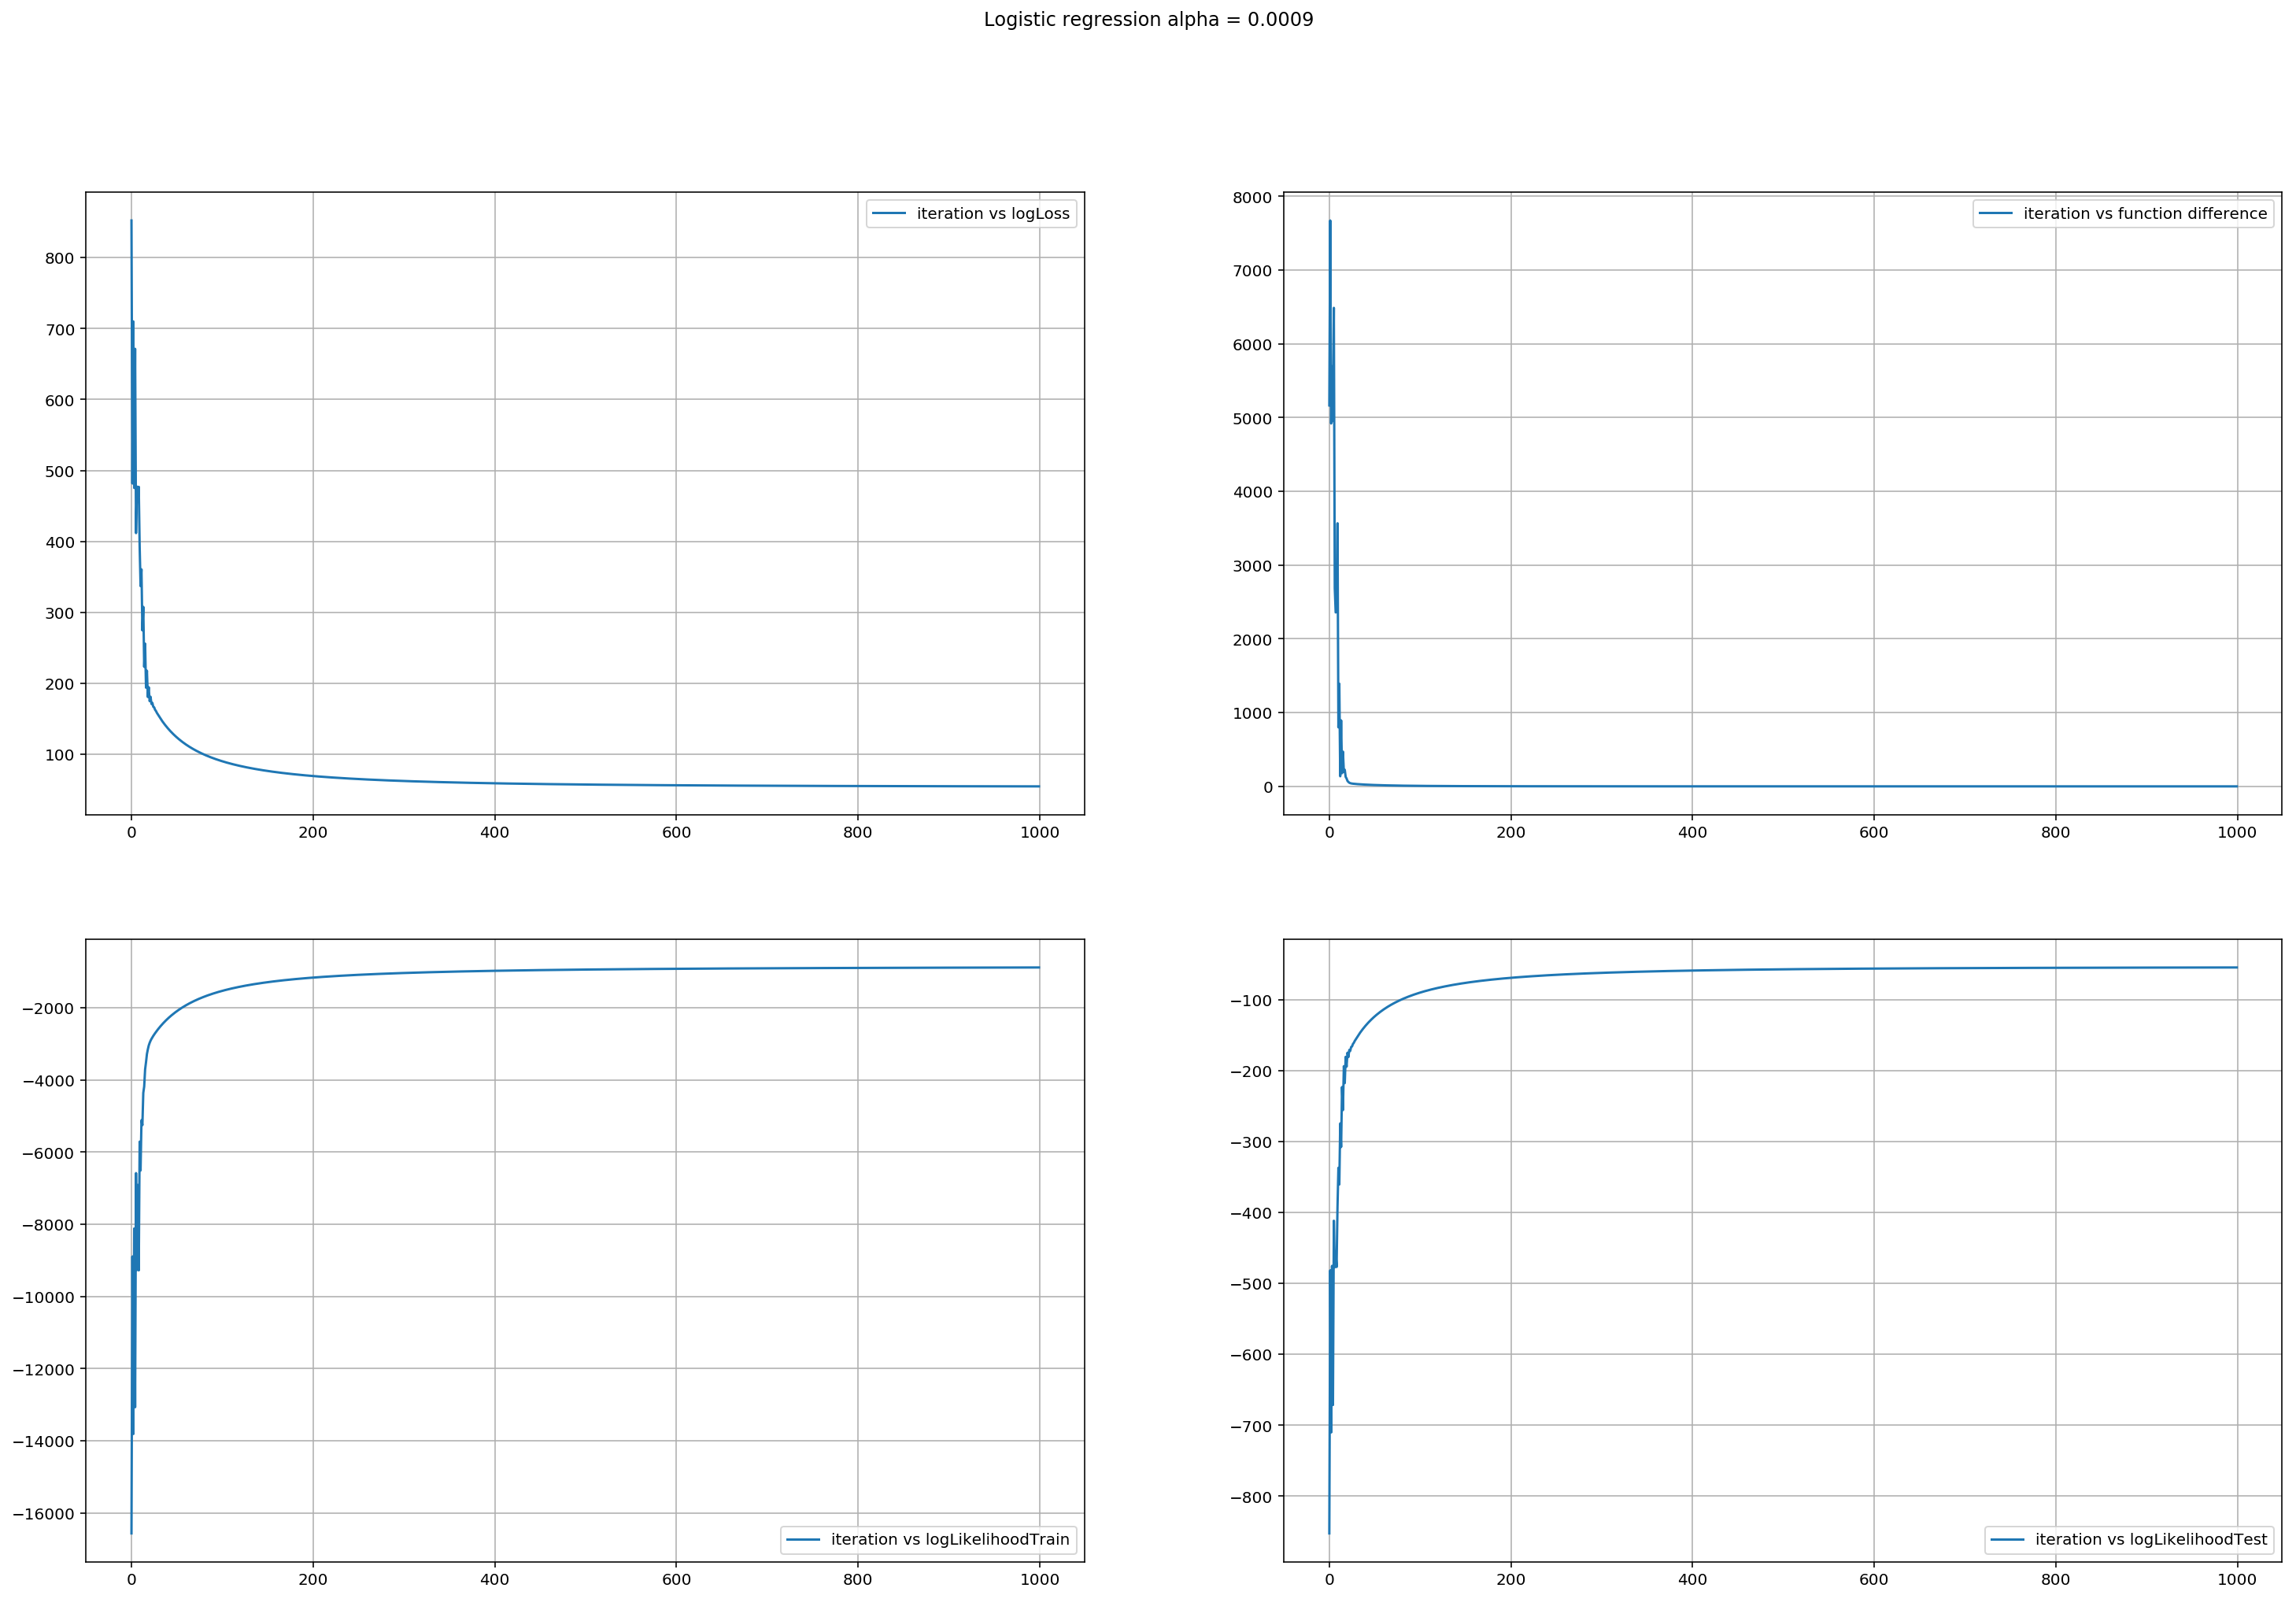

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(25, 16))
plt.suptitle("Logistic regression alpha = " + str(9e-4))
axs[0][0].plot(xAxis, logLossTest, label = "iteration vs logLoss")
axs[0][0].grid()
axs[0][0].legend()


axs[0][1].plot(xAxis, functionDifference, label = "iteration vs function difference")
axs[0][1].grid()
axs[0][1].legend()


axs[1][0].plot(xAxis, logLikelihoodTrain, label = "iteration vs logLikelihoodTrain")
axs[1][0].grid()
axs[1][0].legend()


axs[1][1].plot(xAxis, logLikelihoodTest, label = "iteration vs logLikelihoodTest")
axs[1][1].grid()
axs[1][1].legend()



plt.show()

Here we can see that logloss is decreasing. Furthermore the logloss = -logLikelihood for testset<br>
For both the train set and test set the loglikelihood is increasing hence gradient ascent is working for the provided set.

### Executing stochastic Logistic Regression

In [24]:
"""Here alpha = 5.5e-5 gives better results but it is 
very smooth. For explaining purpose alpha has been increased"""

beta, xAxis, functionDifference, logLossTest, logLikelihoodTrain, logLikelihoodTest = stochasticLogisticRegression(xTrain.as_matrix(), 
                                                                                                                   yTrain.as_matrix(), xTest.as_matrix(), 
                                                                                                                   yTest.as_matrix(), 
                                                                                                                   np.zeros(xTrain.shape[1] + 1), 7e-3, 200)

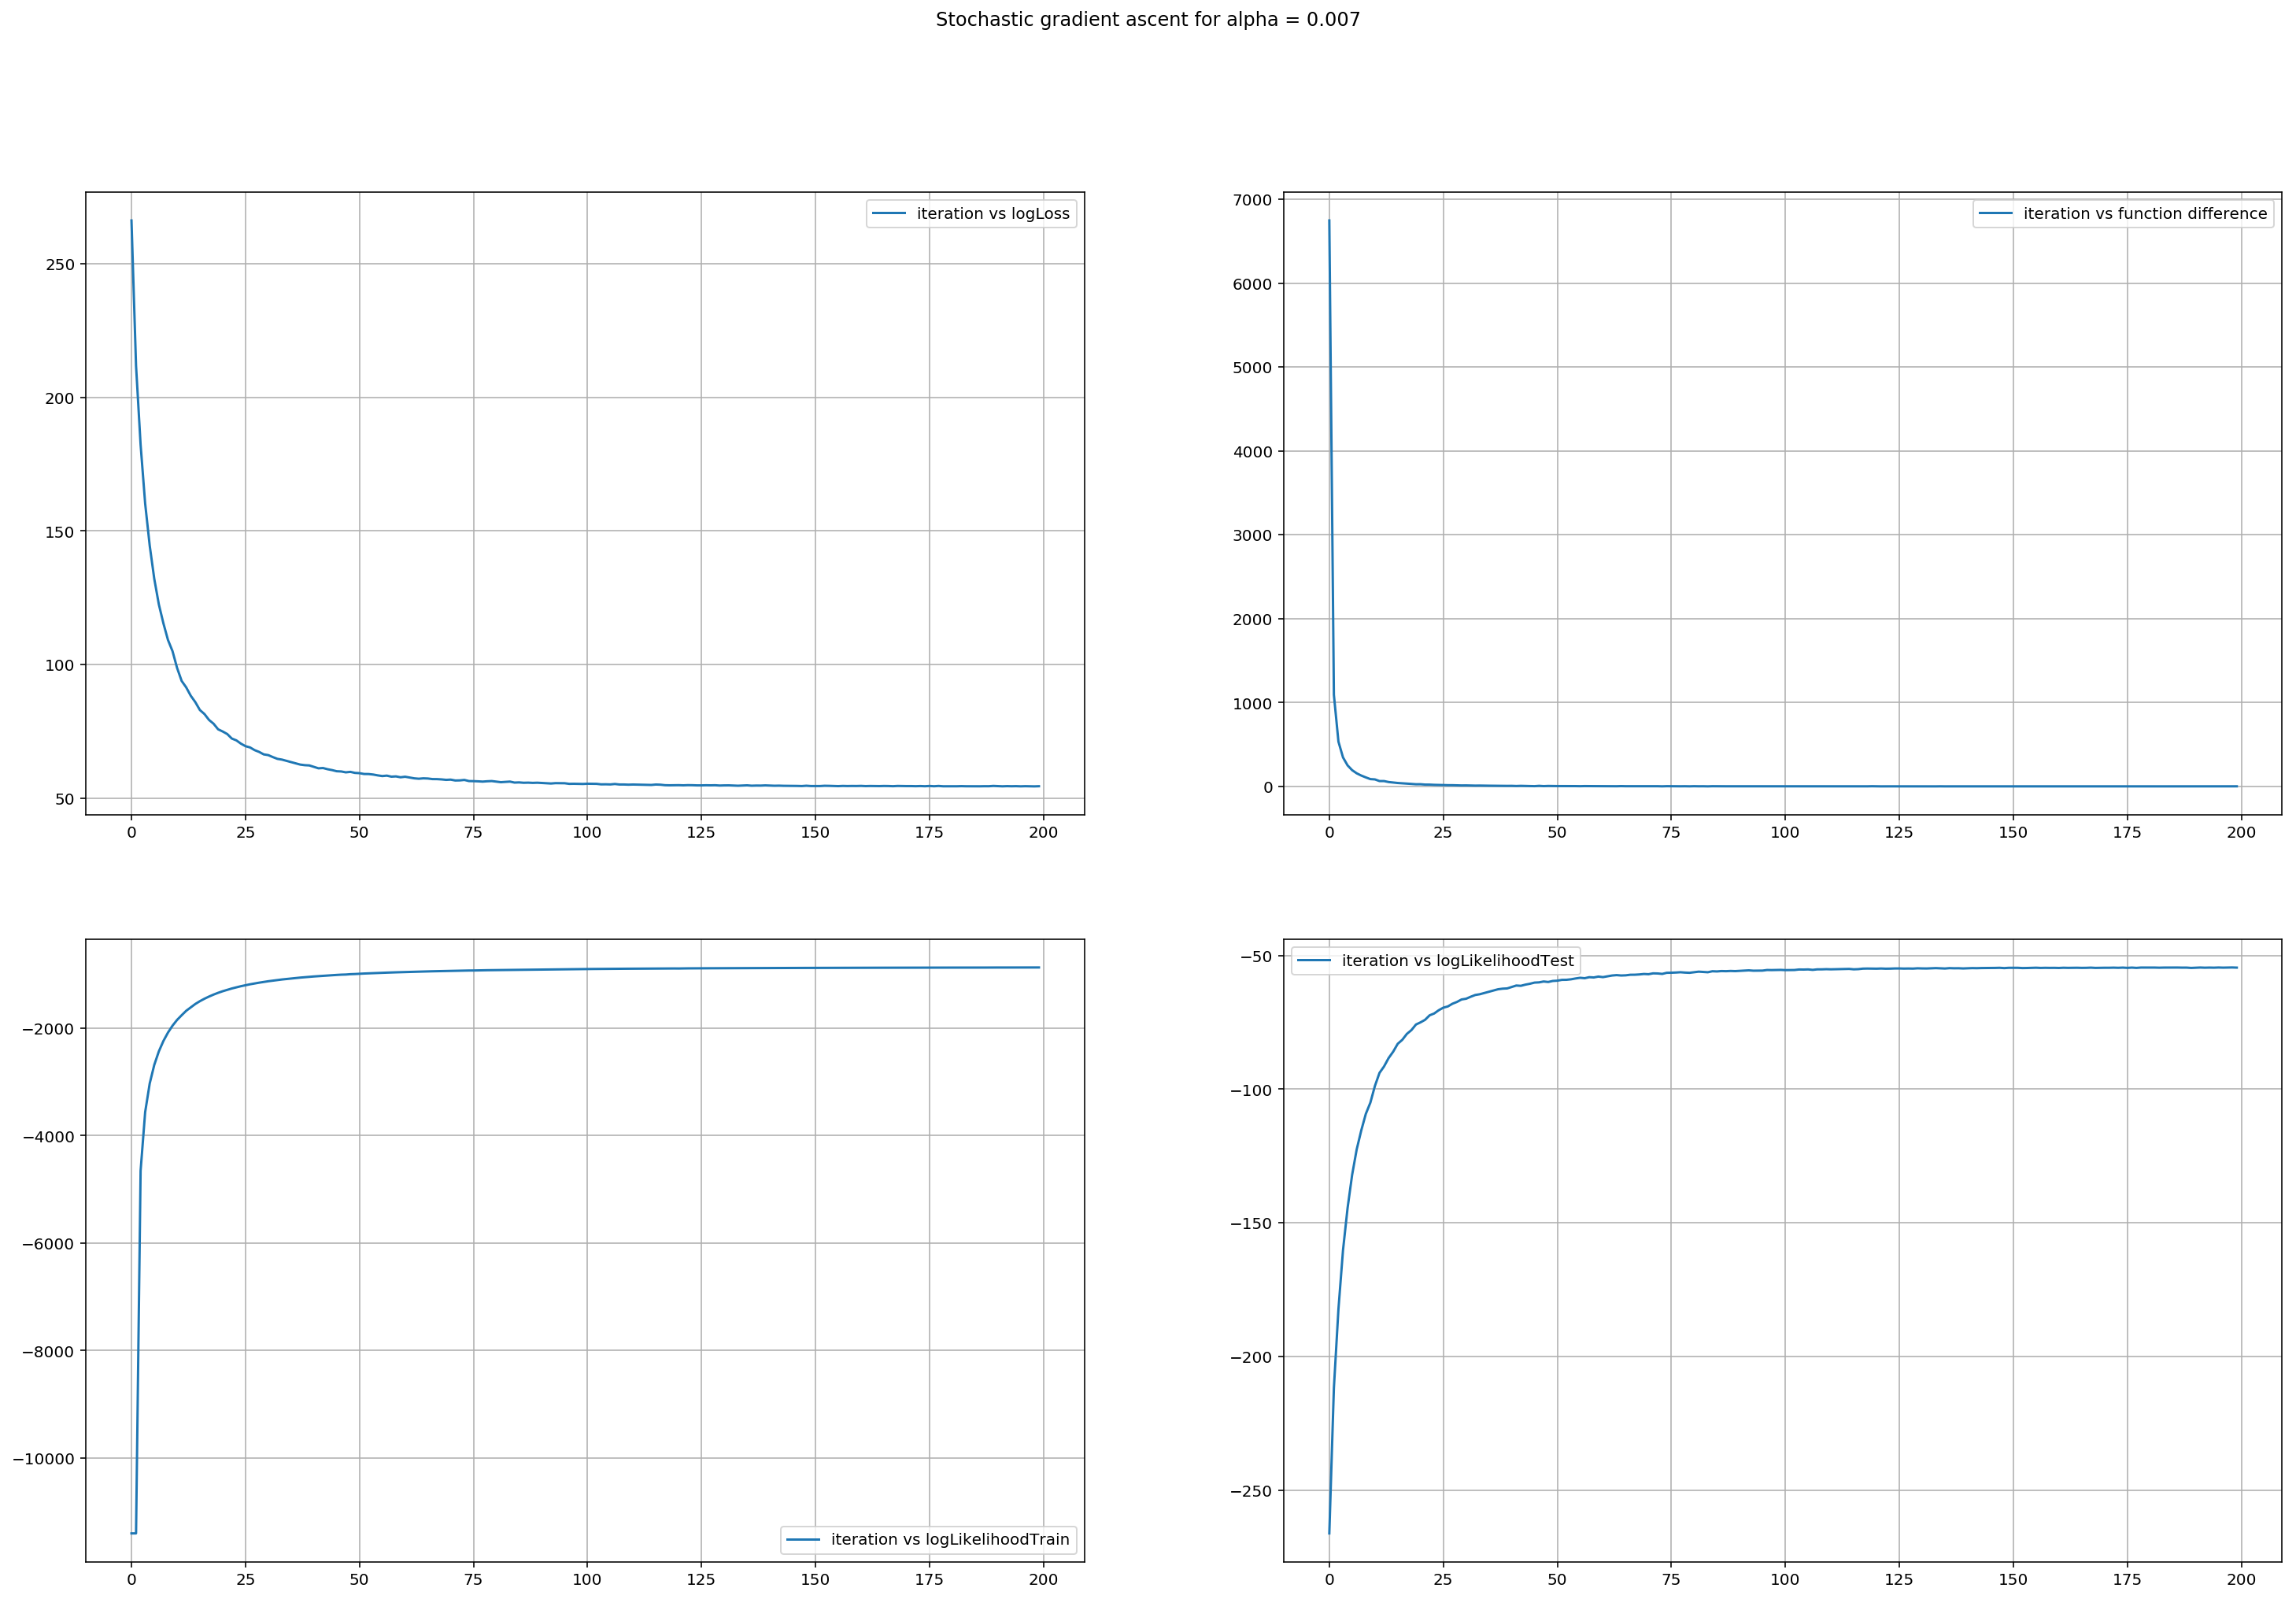

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(25, 16))
plt.suptitle("Stochastic gradient ascent for alpha = " + str(7e-3))

axs[0][0].plot(xAxis, logLossTest, label = "iteration vs logLoss")
axs[0][0].grid()
axs[0][0].legend()


axs[0][1].plot(xAxis, functionDifference, label = "iteration vs function difference")
axs[0][1].grid()
axs[0][1].legend()


axs[1][0].plot(xAxis, logLikelihoodTrain, label = "iteration vs logLikelihoodTrain")
axs[1][0].grid()
axs[1][0].legend()


axs[1][1].plot(xAxis, logLikelihoodTest, label = "iteration vs logLikelihoodTest")
axs[1][1].grid()
axs[1][1].legend()


plt.show()

Loglikelihood for both training and testset are increasing. Which means that gradient ascent is working. Also loglikelihood = -logloss for testset. 

### Stochastic Logistic regression with bold driver step length controller

In [ ]:
beta, xAxis, functionDifference, logLossTest, logLikelihoodTrain, logLikelihoodTest = stochasticLogisticRegression(xTrain.as_matrix(), 
                                                                                                                   yTrain.as_matrix(), xTest.as_matrix(), 
                                                                                                                   yTest.as_matrix(), 
                                                                                                                   np.zeros(xTrain.shape[1] + 1), 1e-5, 500,
                                                                                                                   stepLengthController = boldDriverStepLengthController,
                                                                                                                   stepLengthControllerParameters = {"alphaMinus" : 0.999, "alphaPlus" : 1.001})

Warning using stepLengthController alpha values will be rewritten


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(25, 16))
plt.suptitle("Stochastic gradient ascent with bold driver steplength controller for alphaPlus = " + str(0.999) +
                    " and alphaMinus = " + str(1.001))

axs[0][0].plot(xAxis, logLossTest, label = "iteration vs logLoss")
axs[0][0].grid()
axs[0][0].legend()

axs[0][1].plot(xAxis, functionDifference, label = "iteration vs function difference")
axs[0][1].grid()
axs[0][1].legend()


axs[1][0].plot(xAxis, logLikelihoodTrain, label = "iteration vs logLikelihoodTrain")
axs[1][0].grid()
axs[1][0].legend()


axs[1][1].plot(xAxis, logLikelihoodTest, label = "iteration vs logLikelihoodTest")
axs[1][1].grid()
axs[1][1].legend()


plt.show()

### Stochastic Logistic regression with adagrad step length controller

In [ ]:
beta, xAxis, functionDifference, logLossTest, logLikelihoodTrain, logLikelihoodTest = stochasticLogisticRegression(xTrain.as_matrix(), 
                                                                                                                   yTrain.as_matrix(), xTest.as_matrix(), 
                                                                                                                   yTest.as_matrix(), 
                                                                                                                   np.zeros(xTrain.shape[1] + 1), 1e-5, 250,
                                                                                                                   stepLengthController = adagradController,
                                                                                                                   stepLengthControllerParameters = {"initialStepLength":0.1e-2})

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(25, 16))
plt.suptitle("Stochastic gradient ascent with adagrad steplength controller for initialStepLength = " + str(0.1e-2))

axs[0][0].plot(xAxis, logLossTest, label = "iteration vs logLoss")
axs[0][0].grid()
axs[0][0].legend()


axs[0][1].plot(xAxis, functionDifference, label = "iteration vs function difference")
axs[0][1].grid()
axs[0][1].legend()

axs[1][0].plot(xAxis, logLikelihoodTrain, label = "iteration vs logLikelihoodTrain")
axs[1][0].grid()
axs[1][0].legend()

axs[1][1].plot(xAxis, logLikelihoodTest, label = "iteration vs logLikelihoodTest")
axs[1][1].grid()
axs[1][1].legend()


plt.show()